In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : [],
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_0_t1t2_normalized_e_e_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(491695, 919)
(491695, 8)
validation
(85893, 919)
(85893, 8)
test
(41645, 919)
(41645, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 919)]             0         


 dense (Dense)               (None, 1024)              942080    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1632136 (6.23 MB)


Trainable params: 1632136 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/50 [..............................] - ETA: 1:22 - loss: 2.2765 - STD: 0.0532 - MAE: 0.2237

 4/50 [=>............................] - ETA: 1s - loss: 1.7261 - STD: 0.1051 - MAE: 0.1875  

 7/50 [===>..........................] - ETA: 1s - loss: 1.5917 - STD: 0.1589 - MAE: 0.1646

10/50 [=====>........................] - ETA: 0s - loss: 1.5340 - STD: 0.1767 - MAE: 0.1569

13/50 [======>.......................] - ETA: 0s - loss: 1.5022 - STD: 0.1776 - MAE: 0.1558

16/50 [========>.....................] - ETA: 0s - loss: 1.4808 - STD: 0.1769 - MAE: 0.1557

19/50 [==========>...................] - ETA: 0s - loss: 1.4638 - STD: 0.1791 - MAE: 0.1545

22/50 [============>.................] - ETA: 0s - loss: 1.4523 - STD: 0.1824 - MAE: 0.1531

25/50 [==============>...............] - ETA: 0s - loss: 1.4425 - STD: 0.1845 - MAE: 0.1521

28/50 [===============>..............] - ETA: 0s - loss: 1.4339 - STD: 0.1847 - MAE: 0.1518

31/50 [=================>............] - ETA: 0s - loss: 1.4286 - STD: 0.1839 - MAE: 0.1521

34/50 [===================>..........] - ETA: 0s - loss: 1.4238 - STD: 0.1832 - MAE: 0.1523

37/50 [=====================>........] - ETA: 0s - loss: 1.4193 - STD: 0.1832 - MAE: 0.1522

40/50 [=======================>......] - ETA: 0s - loss: 1.4154 - STD: 0.1836 - MAE: 0.1520

42/50 [========================>.....] - ETA: 0s - loss: 1.4139 - STD: 0.1838 - MAE: 0.1519

45/50 [==========================>...] - ETA: 0s - loss: 1.4103 - STD: 0.1838 - MAE: 0.1518

48/50 [===========================>..] - ETA: 0s - loss: 1.4079 - STD: 0.1836 - MAE: 0.1519

50/50 [==============================] - 4s 56ms/step - loss: 1.4061 - STD: 0.1835 - MAE: 0.1519 - val_loss: 1.3286 - val_STD: 0.1808 - val_MAE: 0.1501


Epoch 2/10000


 1/50 [..............................] - ETA: 2s - loss: 1.3539 - STD: 0.1808 - MAE: 0.1517

 4/50 [=>............................] - ETA: 1s - loss: 1.3529 - STD: 0.1830 - MAE: 0.1507

 7/50 [===>..........................] - ETA: 1s - loss: 1.3550 - STD: 0.1851 - MAE: 0.1500

10/50 [=====>........................] - ETA: 0s - loss: 1.3550 - STD: 0.1860 - MAE: 0.1497

13/50 [======>.......................] - ETA: 0s - loss: 1.3575 - STD: 0.1855 - MAE: 0.1500

16/50 [========>.....................] - ETA: 0s - loss: 1.3600 - STD: 0.1846 - MAE: 0.1505

19/50 [==========>...................] - ETA: 0s - loss: 1.3614 - STD: 0.1840 - MAE: 0.1508

22/50 [============>.................] - ETA: 0s - loss: 1.3608 - STD: 0.1841 - MAE: 0.1507

25/50 [==============>...............] - ETA: 0s - loss: 1.3600 - STD: 0.1842 - MAE: 0.1506

28/50 [===============>..............] - ETA: 0s - loss: 1.3599 - STD: 0.1842 - MAE: 0.1506

31/50 [=================>............] - ETA: 0s - loss: 1.3587 - STD: 0.1842 - MAE: 0.1505

34/50 [===================>..........] - ETA: 0s - loss: 1.3573 - STD: 0.1844 - MAE: 0.1504

37/50 [=====================>........] - ETA: 0s - loss: 1.3561 - STD: 0.1845 - MAE: 0.1503

39/50 [======================>.......] - ETA: 0s - loss: 1.3555 - STD: 0.1844 - MAE: 0.1503

42/50 [========================>.....] - ETA: 0s - loss: 1.3547 - STD: 0.1841 - MAE: 0.1503

45/50 [==========================>...] - ETA: 0s - loss: 1.3521 - STD: 0.1841 - MAE: 0.1501

48/50 [===========================>..] - ETA: 0s - loss: 1.3502 - STD: 0.1842 - MAE: 0.1500

50/50 [==============================] - 1s 29ms/step - loss: 1.3486 - STD: 0.1842 - MAE: 0.1499 - val_loss: 1.2813 - val_STD: 0.1830 - val_MAE: 0.1458


Epoch 3/10000


 1/50 [..............................] - ETA: 2s - loss: 1.2773 - STD: 0.1848 - MAE: 0.1457

 4/50 [=>............................] - ETA: 0s - loss: 1.3025 - STD: 0.1893 - MAE: 0.1449

 7/50 [===>..........................] - ETA: 0s - loss: 1.3049 - STD: 0.1890 - MAE: 0.1453

 9/50 [====>.........................] - ETA: 0s - loss: 1.3032 - STD: 0.1878 - MAE: 0.1457

12/50 [======>.......................] - ETA: 0s - loss: 1.2996 - STD: 0.1893 - MAE: 0.1449

15/50 [========>.....................] - ETA: 0s - loss: 1.2951 - STD: 0.1900 - MAE: 0.1445

18/50 [=========>....................] - ETA: 0s - loss: 1.2931 - STD: 0.1902 - MAE: 0.1443

21/50 [===========>..................] - ETA: 0s - loss: 1.2922 - STD: 0.1906 - MAE: 0.1441

24/50 [=============>................] - ETA: 0s - loss: 1.2921 - STD: 0.1907 - MAE: 0.1441

27/50 [===============>..............] - ETA: 0s - loss: 1.2912 - STD: 0.1910 - MAE: 0.1440

30/50 [=================>............] - ETA: 0s - loss: 1.2892 - STD: 0.1911 - MAE: 0.1439

33/50 [==================>...........] - ETA: 0s - loss: 1.2867 - STD: 0.1913 - MAE: 0.1438

36/50 [====================>.........] - ETA: 0s - loss: 1.2837 - STD: 0.1919 - MAE: 0.1434

39/50 [======================>.......] - ETA: 0s - loss: 1.2806 - STD: 0.1923 - MAE: 0.1431

42/50 [========================>.....] - ETA: 0s - loss: 1.2788 - STD: 0.1924 - MAE: 0.1431

45/50 [==========================>...] - ETA: 0s - loss: 1.2761 - STD: 0.1928 - MAE: 0.1428

48/50 [===========================>..] - ETA: 0s - loss: 1.2734 - STD: 0.1931 - MAE: 0.1426

50/50 [==============================] - 1s 28ms/step - loss: 1.2716 - STD: 0.1932 - MAE: 0.1425 - val_loss: 1.1943 - val_STD: 0.1942 - val_MAE: 0.1374


Epoch 4/10000


 1/50 [..............................] - ETA: 2s - loss: 1.2116 - STD: 0.2054 - MAE: 0.1355

 4/50 [=>............................] - ETA: 1s - loss: 1.2120 - STD: 0.1994 - MAE: 0.1379

 7/50 [===>..........................] - ETA: 1s - loss: 1.2092 - STD: 0.1995 - MAE: 0.1379

10/50 [=====>........................] - ETA: 0s - loss: 1.2085 - STD: 0.1989 - MAE: 0.1382

13/50 [======>.......................] - ETA: 0s - loss: 1.2096 - STD: 0.1986 - MAE: 0.1385

16/50 [========>.....................] - ETA: 0s - loss: 1.2063 - STD: 0.1988 - MAE: 0.1383

19/50 [==========>...................] - ETA: 0s - loss: 1.2011 - STD: 0.1988 - MAE: 0.1381

22/50 [============>.................] - ETA: 0s - loss: 1.1976 - STD: 0.1990 - MAE: 0.1380

25/50 [==============>...............] - ETA: 0s - loss: 1.1946 - STD: 0.1994 - MAE: 0.1377

28/50 [===============>..............] - ETA: 0s - loss: 1.1904 - STD: 0.1996 - MAE: 0.1375

31/50 [=================>............] - ETA: 0s - loss: 1.1870 - STD: 0.1997 - MAE: 0.1374

34/50 [===================>..........] - ETA: 0s - loss: 1.1825 - STD: 0.1999 - MAE: 0.1372

37/50 [=====================>........] - ETA: 0s - loss: 1.1792 - STD: 0.1998 - MAE: 0.1371

40/50 [=======================>......] - ETA: 0s - loss: 1.1762 - STD: 0.2001 - MAE: 0.1370

43/50 [========================>.....] - ETA: 0s - loss: 1.1723 - STD: 0.2002 - MAE: 0.1368

46/50 [==========================>...] - ETA: 0s - loss: 1.1688 - STD: 0.2004 - MAE: 0.1366

49/50 [============================>.] - ETA: 0s - loss: 1.1654 - STD: 0.2004 - MAE: 0.1365

50/50 [==============================] - 1s 28ms/step - loss: 1.1643 - STD: 0.2005 - MAE: 0.1364 - val_loss: 1.0950 - val_STD: 0.1908 - val_MAE: 0.1362


Epoch 5/10000


 1/50 [..............................] - ETA: 2s - loss: 1.1077 - STD: 0.2044 - MAE: 0.1330

 4/50 [=>............................] - ETA: 0s - loss: 1.0971 - STD: 0.2045 - MAE: 0.1326

 7/50 [===>..........................] - ETA: 0s - loss: 1.1005 - STD: 0.2040 - MAE: 0.1330

10/50 [=====>........................] - ETA: 0s - loss: 1.0964 - STD: 0.2041 - MAE: 0.1329

13/50 [======>.......................] - ETA: 0s - loss: 1.0938 - STD: 0.2040 - MAE: 0.1328

16/50 [========>.....................] - ETA: 0s - loss: 1.0906 - STD: 0.2037 - MAE: 0.1328

19/50 [==========>...................] - ETA: 0s - loss: 1.0850 - STD: 0.2044 - MAE: 0.1323

22/50 [============>.................] - ETA: 0s - loss: 1.0793 - STD: 0.2049 - MAE: 0.1318

25/50 [==============>...............] - ETA: 0s - loss: 1.0748 - STD: 0.2056 - MAE: 0.1313

28/50 [===============>..............] - ETA: 0s - loss: 1.0712 - STD: 0.2063 - MAE: 0.1309

31/50 [=================>............] - ETA: 0s - loss: 1.0683 - STD: 0.2068 - MAE: 0.1305

34/50 [===================>..........] - ETA: 0s - loss: 1.0645 - STD: 0.2072 - MAE: 0.1302

37/50 [=====================>........] - ETA: 0s - loss: 1.0606 - STD: 0.2076 - MAE: 0.1298

40/50 [=======================>......] - ETA: 0s - loss: 1.0580 - STD: 0.2080 - MAE: 0.1295

43/50 [========================>.....] - ETA: 0s - loss: 1.0553 - STD: 0.2084 - MAE: 0.1292

46/50 [==========================>...] - ETA: 0s - loss: 1.0525 - STD: 0.2088 - MAE: 0.1289

49/50 [============================>.] - ETA: 0s - loss: 1.0503 - STD: 0.2090 - MAE: 0.1288

50/50 [==============================] - 1s 29ms/step - loss: 1.0494 - STD: 0.2093 - MAE: 0.1286 - val_loss: 1.0231 - val_STD: 0.1998 - val_MAE: 0.1298


Epoch 6/10000


 1/50 [..............................] - ETA: 2s - loss: 1.0069 - STD: 0.2164 - MAE: 0.1238

 4/50 [=>............................] - ETA: 1s - loss: 1.0078 - STD: 0.2159 - MAE: 0.1239

 7/50 [===>..........................] - ETA: 1s - loss: 1.0035 - STD: 0.2158 - MAE: 0.1237

10/50 [=====>........................] - ETA: 0s - loss: 1.0014 - STD: 0.2158 - MAE: 0.1234

13/50 [======>.......................] - ETA: 0s - loss: 0.9996 - STD: 0.2165 - MAE: 0.1230

16/50 [========>.....................] - ETA: 0s - loss: 0.9988 - STD: 0.2170 - MAE: 0.1227

19/50 [==========>...................] - ETA: 0s - loss: 0.9980 - STD: 0.2174 - MAE: 0.1226

22/50 [============>.................] - ETA: 0s - loss: 0.9975 - STD: 0.2166 - MAE: 0.1229

25/50 [==============>...............] - ETA: 0s - loss: 0.9964 - STD: 0.2165 - MAE: 0.1229

28/50 [===============>..............] - ETA: 0s - loss: 0.9942 - STD: 0.2171 - MAE: 0.1225

31/50 [=================>............] - ETA: 0s - loss: 0.9926 - STD: 0.2170 - MAE: 0.1225

34/50 [===================>..........] - ETA: 0s - loss: 0.9906 - STD: 0.2170 - MAE: 0.1224

37/50 [=====================>........] - ETA: 0s - loss: 0.9891 - STD: 0.2173 - MAE: 0.1222

40/50 [=======================>......] - ETA: 0s - loss: 0.9868 - STD: 0.2177 - MAE: 0.1219

42/50 [========================>.....] - ETA: 0s - loss: 0.9855 - STD: 0.2176 - MAE: 0.1219

45/50 [==========================>...] - ETA: 0s - loss: 0.9828 - STD: 0.2180 - MAE: 0.1216

47/50 [===========================>..] - ETA: 0s - loss: 0.9813 - STD: 0.2180 - MAE: 0.1216

50/50 [==============================] - ETA: 0s - loss: 0.9784 - STD: 0.2183 - MAE: 0.1213

50/50 [==============================] - 1s 29ms/step - loss: 0.9784 - STD: 0.2183 - MAE: 0.1213 - val_loss: 0.9837 - val_STD: 0.2076 - val_MAE: 0.1256


Epoch 7/10000


 1/50 [..............................] - ETA: 2s - loss: 0.9283 - STD: 0.2264 - MAE: 0.1156

 4/50 [=>............................] - ETA: 1s - loss: 0.9333 - STD: 0.2237 - MAE: 0.1169

 7/50 [===>..........................] - ETA: 1s - loss: 0.9306 - STD: 0.2235 - MAE: 0.1169

10/50 [=====>........................] - ETA: 0s - loss: 0.9283 - STD: 0.2235 - MAE: 0.1168

13/50 [======>.......................] - ETA: 0s - loss: 0.9276 - STD: 0.2234 - MAE: 0.1168

16/50 [========>.....................] - ETA: 0s - loss: 0.9245 - STD: 0.2236 - MAE: 0.1166

19/50 [==========>...................] - ETA: 0s - loss: 0.9228 - STD: 0.2237 - MAE: 0.1166

22/50 [============>.................] - ETA: 0s - loss: 0.9194 - STD: 0.2239 - MAE: 0.1164

25/50 [==============>...............] - ETA: 0s - loss: 0.9173 - STD: 0.2242 - MAE: 0.1162

28/50 [===============>..............] - ETA: 0s - loss: 0.9157 - STD: 0.2242 - MAE: 0.1161

31/50 [=================>............] - ETA: 0s - loss: 0.9130 - STD: 0.2244 - MAE: 0.1159

34/50 [===================>..........] - ETA: 0s - loss: 0.9109 - STD: 0.2245 - MAE: 0.1158

37/50 [=====================>........] - ETA: 0s - loss: 0.9088 - STD: 0.2247 - MAE: 0.1156

40/50 [=======================>......] - ETA: 0s - loss: 0.9068 - STD: 0.2248 - MAE: 0.1155

43/50 [========================>.....] - ETA: 0s - loss: 0.9055 - STD: 0.2249 - MAE: 0.1154

46/50 [==========================>...] - ETA: 0s - loss: 0.9035 - STD: 0.2252 - MAE: 0.1153

49/50 [============================>.] - ETA: 0s - loss: 0.9012 - STD: 0.2253 - MAE: 0.1151

50/50 [==============================] - 1s 28ms/step - loss: 0.9004 - STD: 0.2254 - MAE: 0.1150 - val_loss: 0.9274 - val_STD: 0.2089 - val_MAE: 0.1242


Epoch 8/10000


 1/50 [..............................] - ETA: 2s - loss: 0.8890 - STD: 0.2233 - MAE: 0.1156

 4/50 [=>............................] - ETA: 1s - loss: 0.8717 - STD: 0.2276 - MAE: 0.1128

 7/50 [===>..........................] - ETA: 1s - loss: 0.8700 - STD: 0.2278 - MAE: 0.1127

10/50 [=====>........................] - ETA: 0s - loss: 0.8708 - STD: 0.2281 - MAE: 0.1127

13/50 [======>.......................] - ETA: 0s - loss: 0.8688 - STD: 0.2287 - MAE: 0.1124

16/50 [========>.....................] - ETA: 0s - loss: 0.8688 - STD: 0.2286 - MAE: 0.1125

19/50 [==========>...................] - ETA: 0s - loss: 0.8688 - STD: 0.2287 - MAE: 0.1125

22/50 [============>.................] - ETA: 0s - loss: 0.8679 - STD: 0.2292 - MAE: 0.1123

25/50 [==============>...............] - ETA: 0s - loss: 0.8665 - STD: 0.2292 - MAE: 0.1122

28/50 [===============>..............] - ETA: 0s - loss: 0.8641 - STD: 0.2292 - MAE: 0.1121

31/50 [=================>............] - ETA: 0s - loss: 0.8623 - STD: 0.2293 - MAE: 0.1120

34/50 [===================>..........] - ETA: 0s - loss: 0.8598 - STD: 0.2294 - MAE: 0.1118

37/50 [=====================>........] - ETA: 0s - loss: 0.8578 - STD: 0.2297 - MAE: 0.1115

40/50 [=======================>......] - ETA: 0s - loss: 0.8568 - STD: 0.2299 - MAE: 0.1114

43/50 [========================>.....] - ETA: 0s - loss: 0.8557 - STD: 0.2301 - MAE: 0.1112

46/50 [==========================>...] - ETA: 0s - loss: 0.8547 - STD: 0.2303 - MAE: 0.1111

49/50 [============================>.] - ETA: 0s - loss: 0.8534 - STD: 0.2304 - MAE: 0.1110

50/50 [==============================] - 1s 28ms/step - loss: 0.8530 - STD: 0.2303 - MAE: 0.1110 - val_loss: 0.8871 - val_STD: 0.2155 - val_MAE: 0.1191


Epoch 9/10000


 1/50 [..............................] - ETA: 2s - loss: 0.8207 - STD: 0.2325 - MAE: 0.1080

 4/50 [=>............................] - ETA: 1s - loss: 0.8266 - STD: 0.2321 - MAE: 0.1088

 7/50 [===>..........................] - ETA: 1s - loss: 0.8312 - STD: 0.2322 - MAE: 0.1091

10/50 [=====>........................] - ETA: 0s - loss: 0.8311 - STD: 0.2328 - MAE: 0.1088

13/50 [======>.......................] - ETA: 0s - loss: 0.8308 - STD: 0.2330 - MAE: 0.1088

16/50 [========>.....................] - ETA: 0s - loss: 0.8323 - STD: 0.2334 - MAE: 0.1087

19/50 [==========>...................] - ETA: 0s - loss: 0.8328 - STD: 0.2334 - MAE: 0.1087

22/50 [============>.................] - ETA: 0s - loss: 0.8319 - STD: 0.2333 - MAE: 0.1087

25/50 [==============>...............] - ETA: 0s - loss: 0.8319 - STD: 0.2331 - MAE: 0.1088

28/50 [===============>..............] - ETA: 0s - loss: 0.8308 - STD: 0.2331 - MAE: 0.1088

31/50 [=================>............] - ETA: 0s - loss: 0.8296 - STD: 0.2331 - MAE: 0.1087

34/50 [===================>..........] - ETA: 0s - loss: 0.8283 - STD: 0.2332 - MAE: 0.1085

37/50 [=====================>........] - ETA: 0s - loss: 0.8276 - STD: 0.2332 - MAE: 0.1085

40/50 [=======================>......] - ETA: 0s - loss: 0.8271 - STD: 0.2333 - MAE: 0.1085

43/50 [========================>.....] - ETA: 0s - loss: 0.8275 - STD: 0.2333 - MAE: 0.1085

46/50 [==========================>...] - ETA: 0s - loss: 0.8270 - STD: 0.2333 - MAE: 0.1085

49/50 [============================>.] - ETA: 0s - loss: 0.8263 - STD: 0.2334 - MAE: 0.1084

50/50 [==============================] - 1s 28ms/step - loss: 0.8260 - STD: 0.2334 - MAE: 0.1084 - val_loss: 0.8833 - val_STD: 0.2145 - val_MAE: 0.1196


Epoch 10/10000


 1/50 [..............................] - ETA: 2s - loss: 0.8308 - STD: 0.2314 - MAE: 0.1098

 3/50 [>.............................] - ETA: 1s - loss: 0.8257 - STD: 0.2345 - MAE: 0.1081

 6/50 [==>...........................] - ETA: 1s - loss: 0.8263 - STD: 0.2334 - MAE: 0.1085

 9/50 [====>.........................] - ETA: 1s - loss: 0.8228 - STD: 0.2334 - MAE: 0.1083

12/50 [======>.......................] - ETA: 0s - loss: 0.8211 - STD: 0.2337 - MAE: 0.1081

15/50 [========>.....................] - ETA: 0s - loss: 0.8188 - STD: 0.2339 - MAE: 0.1078

18/50 [=========>....................] - ETA: 0s - loss: 0.8167 - STD: 0.2344 - MAE: 0.1074

21/50 [===========>..................] - ETA: 0s - loss: 0.8166 - STD: 0.2343 - MAE: 0.1075

24/50 [=============>................] - ETA: 0s - loss: 0.8158 - STD: 0.2346 - MAE: 0.1073

27/50 [===============>..............] - ETA: 0s - loss: 0.8146 - STD: 0.2349 - MAE: 0.1071

30/50 [=================>............] - ETA: 0s - loss: 0.8139 - STD: 0.2349 - MAE: 0.1070

33/50 [==================>...........] - ETA: 0s - loss: 0.8136 - STD: 0.2352 - MAE: 0.1069

36/50 [====================>.........] - ETA: 0s - loss: 0.8123 - STD: 0.2353 - MAE: 0.1068

39/50 [======================>.......] - ETA: 0s - loss: 0.8113 - STD: 0.2353 - MAE: 0.1067

42/50 [========================>.....] - ETA: 0s - loss: 0.8104 - STD: 0.2355 - MAE: 0.1066

45/50 [==========================>...] - ETA: 0s - loss: 0.8096 - STD: 0.2355 - MAE: 0.1066

48/50 [===========================>..] - ETA: 0s - loss: 0.8090 - STD: 0.2356 - MAE: 0.1065

50/50 [==============================] - 1s 28ms/step - loss: 0.8084 - STD: 0.2356 - MAE: 0.1064 - val_loss: 0.8773 - val_STD: 0.2198 - val_MAE: 0.1174


Epoch 11/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7985 - STD: 0.2365 - MAE: 0.1059

 4/50 [=>............................] - ETA: 1s - loss: 0.7962 - STD: 0.2364 - MAE: 0.1054

 7/50 [===>..........................] - ETA: 1s - loss: 0.7957 - STD: 0.2366 - MAE: 0.1053

10/50 [=====>........................] - ETA: 0s - loss: 0.7975 - STD: 0.2360 - MAE: 0.1058

13/50 [======>.......................] - ETA: 0s - loss: 0.7957 - STD: 0.2367 - MAE: 0.1054

16/50 [========>.....................] - ETA: 0s - loss: 0.7959 - STD: 0.2367 - MAE: 0.1054

19/50 [==========>...................] - ETA: 0s - loss: 0.7965 - STD: 0.2365 - MAE: 0.1055

22/50 [============>.................] - ETA: 0s - loss: 0.7953 - STD: 0.2368 - MAE: 0.1053

25/50 [==============>...............] - ETA: 0s - loss: 0.7948 - STD: 0.2368 - MAE: 0.1053

28/50 [===============>..............] - ETA: 0s - loss: 0.7945 - STD: 0.2370 - MAE: 0.1051

31/50 [=================>............] - ETA: 0s - loss: 0.7944 - STD: 0.2372 - MAE: 0.1050

34/50 [===================>..........] - ETA: 0s - loss: 0.7947 - STD: 0.2372 - MAE: 0.1051

37/50 [=====================>........] - ETA: 0s - loss: 0.7950 - STD: 0.2371 - MAE: 0.1051

40/50 [=======================>......] - ETA: 0s - loss: 0.7940 - STD: 0.2371 - MAE: 0.1050

43/50 [========================>.....] - ETA: 0s - loss: 0.7939 - STD: 0.2371 - MAE: 0.1050

46/50 [==========================>...] - ETA: 0s - loss: 0.7931 - STD: 0.2372 - MAE: 0.1049

49/50 [============================>.] - ETA: 0s - loss: 0.7925 - STD: 0.2373 - MAE: 0.1049

50/50 [==============================] - 1s 28ms/step - loss: 0.7922 - STD: 0.2374 - MAE: 0.1048 - val_loss: 0.8755 - val_STD: 0.2221 - val_MAE: 0.1161


Epoch 12/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7873 - STD: 0.2395 - MAE: 0.1032

 4/50 [=>............................] - ETA: 1s - loss: 0.7869 - STD: 0.2384 - MAE: 0.1039

 7/50 [===>..........................] - ETA: 1s - loss: 0.7875 - STD: 0.2383 - MAE: 0.1042

10/50 [=====>........................] - ETA: 0s - loss: 0.7857 - STD: 0.2381 - MAE: 0.1041

13/50 [======>.......................] - ETA: 0s - loss: 0.7855 - STD: 0.2379 - MAE: 0.1043

15/50 [========>.....................] - ETA: 0s - loss: 0.7873 - STD: 0.2384 - MAE: 0.1042

18/50 [=========>....................] - ETA: 0s - loss: 0.7883 - STD: 0.2385 - MAE: 0.1042

21/50 [===========>..................] - ETA: 0s - loss: 0.7890 - STD: 0.2384 - MAE: 0.1043

24/50 [=============>................] - ETA: 0s - loss: 0.7888 - STD: 0.2385 - MAE: 0.1042

27/50 [===============>..............] - ETA: 0s - loss: 0.7881 - STD: 0.2385 - MAE: 0.1042

30/50 [=================>............] - ETA: 0s - loss: 0.7885 - STD: 0.2381 - MAE: 0.1044

33/50 [==================>...........] - ETA: 0s - loss: 0.7898 - STD: 0.2381 - MAE: 0.1045

36/50 [====================>.........] - ETA: 0s - loss: 0.7904 - STD: 0.2383 - MAE: 0.1044

39/50 [======================>.......] - ETA: 0s - loss: 0.7896 - STD: 0.2385 - MAE: 0.1043

42/50 [========================>.....] - ETA: 0s - loss: 0.7891 - STD: 0.2385 - MAE: 0.1043

45/50 [==========================>...] - ETA: 0s - loss: 0.7882 - STD: 0.2384 - MAE: 0.1043

48/50 [===========================>..] - ETA: 0s - loss: 0.7868 - STD: 0.2384 - MAE: 0.1042

50/50 [==============================] - 1s 28ms/step - loss: 0.7863 - STD: 0.2384 - MAE: 0.1042 - val_loss: 0.9027 - val_STD: 0.2172 - val_MAE: 0.1204


Epoch 13/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7558 - STD: 0.2347 - MAE: 0.1039

 4/50 [=>............................] - ETA: 1s - loss: 0.7672 - STD: 0.2391 - MAE: 0.1026

 7/50 [===>..........................] - ETA: 0s - loss: 0.7674 - STD: 0.2402 - MAE: 0.1021

10/50 [=====>........................] - ETA: 0s - loss: 0.7692 - STD: 0.2400 - MAE: 0.1023

13/50 [======>.......................] - ETA: 0s - loss: 0.7700 - STD: 0.2399 - MAE: 0.1024

16/50 [========>.....................] - ETA: 0s - loss: 0.7701 - STD: 0.2397 - MAE: 0.1026

19/50 [==========>...................] - ETA: 0s - loss: 0.7709 - STD: 0.2397 - MAE: 0.1026

22/50 [============>.................] - ETA: 0s - loss: 0.7725 - STD: 0.2400 - MAE: 0.1026

25/50 [==============>...............] - ETA: 0s - loss: 0.7726 - STD: 0.2401 - MAE: 0.1026

28/50 [===============>..............] - ETA: 0s - loss: 0.7732 - STD: 0.2400 - MAE: 0.1027

31/50 [=================>............] - ETA: 0s - loss: 0.7746 - STD: 0.2399 - MAE: 0.1028

34/50 [===================>..........] - ETA: 0s - loss: 0.7731 - STD: 0.2399 - MAE: 0.1027

37/50 [=====================>........] - ETA: 0s - loss: 0.7728 - STD: 0.2398 - MAE: 0.1027

40/50 [=======================>......] - ETA: 0s - loss: 0.7726 - STD: 0.2399 - MAE: 0.1027

43/50 [========================>.....] - ETA: 0s - loss: 0.7725 - STD: 0.2399 - MAE: 0.1027

46/50 [==========================>...] - ETA: 0s - loss: 0.7720 - STD: 0.2399 - MAE: 0.1026

49/50 [============================>.] - ETA: 0s - loss: 0.7716 - STD: 0.2400 - MAE: 0.1026

50/50 [==============================] - 1s 28ms/step - loss: 0.7717 - STD: 0.2400 - MAE: 0.1026 - val_loss: 0.8908 - val_STD: 0.2268 - val_MAE: 0.1151


Epoch 14/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7624 - STD: 0.2427 - MAE: 0.1008

 4/50 [=>............................] - ETA: 1s - loss: 0.7729 - STD: 0.2410 - MAE: 0.1020

 7/50 [===>..........................] - ETA: 1s - loss: 0.7706 - STD: 0.2409 - MAE: 0.1020

10/50 [=====>........................] - ETA: 0s - loss: 0.7699 - STD: 0.2407 - MAE: 0.1021

13/50 [======>.......................] - ETA: 0s - loss: 0.7690 - STD: 0.2407 - MAE: 0.1021

16/50 [========>.....................] - ETA: 0s - loss: 0.7679 - STD: 0.2406 - MAE: 0.1021

19/50 [==========>...................] - ETA: 0s - loss: 0.7672 - STD: 0.2405 - MAE: 0.1020

22/50 [============>.................] - ETA: 0s - loss: 0.7652 - STD: 0.2407 - MAE: 0.1018

25/50 [==============>...............] - ETA: 0s - loss: 0.7631 - STD: 0.2408 - MAE: 0.1017

28/50 [===============>..............] - ETA: 0s - loss: 0.7619 - STD: 0.2408 - MAE: 0.1017

31/50 [=================>............] - ETA: 0s - loss: 0.7618 - STD: 0.2408 - MAE: 0.1017

34/50 [===================>..........] - ETA: 0s - loss: 0.7618 - STD: 0.2409 - MAE: 0.1016

37/50 [=====================>........] - ETA: 0s - loss: 0.7615 - STD: 0.2410 - MAE: 0.1016

40/50 [=======================>......] - ETA: 0s - loss: 0.7607 - STD: 0.2410 - MAE: 0.1015

43/50 [========================>.....] - ETA: 0s - loss: 0.7604 - STD: 0.2410 - MAE: 0.1015

46/50 [==========================>...] - ETA: 0s - loss: 0.7602 - STD: 0.2410 - MAE: 0.1015

49/50 [============================>.] - ETA: 0s - loss: 0.7595 - STD: 0.2410 - MAE: 0.1015

50/50 [==============================] - 1s 28ms/step - loss: 0.7590 - STD: 0.2410 - MAE: 0.1015 - val_loss: 0.9213 - val_STD: 0.2250 - val_MAE: 0.1174


Epoch 15/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7380 - STD: 0.2406 - MAE: 0.1005

 4/50 [=>............................] - ETA: 1s - loss: 0.7437 - STD: 0.2415 - MAE: 0.1003

 7/50 [===>..........................] - ETA: 0s - loss: 0.7465 - STD: 0.2418 - MAE: 0.1004

10/50 [=====>........................] - ETA: 0s - loss: 0.7468 - STD: 0.2418 - MAE: 0.1004

13/50 [======>.......................] - ETA: 0s - loss: 0.7490 - STD: 0.2421 - MAE: 0.1004

16/50 [========>.....................] - ETA: 0s - loss: 0.7512 - STD: 0.2422 - MAE: 0.1004

19/50 [==========>...................] - ETA: 0s - loss: 0.7528 - STD: 0.2421 - MAE: 0.1006

22/50 [============>.................] - ETA: 0s - loss: 0.7522 - STD: 0.2421 - MAE: 0.1006

25/50 [==============>...............] - ETA: 0s - loss: 0.7519 - STD: 0.2422 - MAE: 0.1005

28/50 [===============>..............] - ETA: 0s - loss: 0.7508 - STD: 0.2423 - MAE: 0.1004

31/50 [=================>............] - ETA: 0s - loss: 0.7508 - STD: 0.2421 - MAE: 0.1005

34/50 [===================>..........] - ETA: 0s - loss: 0.7504 - STD: 0.2420 - MAE: 0.1005

37/50 [=====================>........] - ETA: 0s - loss: 0.7508 - STD: 0.2421 - MAE: 0.1005

39/50 [======================>.......] - ETA: 0s - loss: 0.7499 - STD: 0.2422 - MAE: 0.1004

42/50 [========================>.....] - ETA: 0s - loss: 0.7496 - STD: 0.2422 - MAE: 0.1004

45/50 [==========================>...] - ETA: 0s - loss: 0.7492 - STD: 0.2423 - MAE: 0.1003

48/50 [===========================>..] - ETA: 0s - loss: 0.7490 - STD: 0.2423 - MAE: 0.1003

50/50 [==============================] - 1s 28ms/step - loss: 0.7486 - STD: 0.2424 - MAE: 0.1003 - val_loss: 0.9350 - val_STD: 0.2252 - val_MAE: 0.1193


Epoch 16/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7399 - STD: 0.2399 - MAE: 0.1008

 4/50 [=>............................] - ETA: 0s - loss: 0.7439 - STD: 0.2420 - MAE: 0.1002

 6/50 [==>...........................] - ETA: 0s - loss: 0.7488 - STD: 0.2424 - MAE: 0.1003

 9/50 [====>.........................] - ETA: 0s - loss: 0.7445 - STD: 0.2434 - MAE: 0.0995

12/50 [======>.......................] - ETA: 0s - loss: 0.7462 - STD: 0.2437 - MAE: 0.0995

15/50 [========>.....................] - ETA: 0s - loss: 0.7465 - STD: 0.2432 - MAE: 0.0998

18/50 [=========>....................] - ETA: 0s - loss: 0.7441 - STD: 0.2434 - MAE: 0.0996

21/50 [===========>..................] - ETA: 0s - loss: 0.7436 - STD: 0.2431 - MAE: 0.0997

24/50 [=============>................] - ETA: 0s - loss: 0.7419 - STD: 0.2432 - MAE: 0.0996

27/50 [===============>..............] - ETA: 0s - loss: 0.7416 - STD: 0.2432 - MAE: 0.0995

29/50 [================>.............] - ETA: 0s - loss: 0.7410 - STD: 0.2433 - MAE: 0.0994

32/50 [==================>...........] - ETA: 0s - loss: 0.7407 - STD: 0.2433 - MAE: 0.0994

35/50 [====================>.........] - ETA: 0s - loss: 0.7413 - STD: 0.2432 - MAE: 0.0995

38/50 [=====================>........] - ETA: 0s - loss: 0.7402 - STD: 0.2432 - MAE: 0.0994

41/50 [=======================>......] - ETA: 0s - loss: 0.7410 - STD: 0.2433 - MAE: 0.0994

44/50 [=========================>....] - ETA: 0s - loss: 0.7418 - STD: 0.2432 - MAE: 0.0995

47/50 [===========================>..] - ETA: 0s - loss: 0.7419 - STD: 0.2432 - MAE: 0.0995

50/50 [==============================] - ETA: 0s - loss: 0.7408 - STD: 0.2433 - MAE: 0.0994

50/50 [==============================] - 1s 28ms/step - loss: 0.7408 - STD: 0.2433 - MAE: 0.0994 - val_loss: 0.9588 - val_STD: 0.2271 - val_MAE: 0.1189


Epoch 17/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7341 - STD: 0.2412 - MAE: 0.1000

 4/50 [=>............................] - ETA: 1s - loss: 0.7380 - STD: 0.2435 - MAE: 0.0991

 7/50 [===>..........................] - ETA: 1s - loss: 0.7355 - STD: 0.2438 - MAE: 0.0988

10/50 [=====>........................] - ETA: 0s - loss: 0.7338 - STD: 0.2438 - MAE: 0.0989

12/50 [======>.......................] - ETA: 0s - loss: 0.7445 - STD: 0.2440 - MAE: 0.0995

15/50 [========>.....................] - ETA: 0s - loss: 0.7472 - STD: 0.2439 - MAE: 0.0998

18/50 [=========>....................] - ETA: 0s - loss: 0.7467 - STD: 0.2439 - MAE: 0.0997

21/50 [===========>..................] - ETA: 0s - loss: 0.7448 - STD: 0.2439 - MAE: 0.0995

24/50 [=============>................] - ETA: 0s - loss: 0.7449 - STD: 0.2437 - MAE: 0.0996

27/50 [===============>..............] - ETA: 0s - loss: 0.7445 - STD: 0.2435 - MAE: 0.0996

30/50 [=================>............] - ETA: 0s - loss: 0.7433 - STD: 0.2435 - MAE: 0.0996

33/50 [==================>...........] - ETA: 0s - loss: 0.7427 - STD: 0.2434 - MAE: 0.0996

36/50 [====================>.........] - ETA: 0s - loss: 0.7408 - STD: 0.2435 - MAE: 0.0995

39/50 [======================>.......] - ETA: 0s - loss: 0.7404 - STD: 0.2436 - MAE: 0.0994

42/50 [========================>.....] - ETA: 0s - loss: 0.7403 - STD: 0.2438 - MAE: 0.0993

45/50 [==========================>...] - ETA: 0s - loss: 0.7393 - STD: 0.2439 - MAE: 0.0992

48/50 [===========================>..] - ETA: 0s - loss: 0.7381 - STD: 0.2439 - MAE: 0.0991

50/50 [==============================] - 1s 28ms/step - loss: 0.7371 - STD: 0.2439 - MAE: 0.0990 - val_loss: 0.9407 - val_STD: 0.2320 - val_MAE: 0.1162


Epoch 18/10000


 1/50 [..............................] - ETA: 2s - loss: 0.7218 - STD: 0.2460 - MAE: 0.0969

 4/50 [=>............................] - ETA: 1s - loss: 0.7167 - STD: 0.2452 - MAE: 0.0971

 7/50 [===>..........................] - ETA: 1s - loss: 0.7208 - STD: 0.2452 - MAE: 0.0975

10/50 [=====>........................] - ETA: 0s - loss: 0.7250 - STD: 0.2450 - MAE: 0.0978

13/50 [======>.......................] - ETA: 0s - loss: 0.7240 - STD: 0.2451 - MAE: 0.0976

16/50 [========>.....................] - ETA: 0s - loss: 0.7248 - STD: 0.2451 - MAE: 0.0976

19/50 [==========>...................] - ETA: 0s - loss: 0.7257 - STD: 0.2450 - MAE: 0.0977

22/50 [============>.................] - ETA: 0s - loss: 0.7287 - STD: 0.2450 - MAE: 0.0979

25/50 [==============>...............] - ETA: 0s - loss: 0.7290 - STD: 0.2450 - MAE: 0.0979

28/50 [===============>..............] - ETA: 0s - loss: 0.7288 - STD: 0.2451 - MAE: 0.0979

31/50 [=================>............] - ETA: 0s - loss: 0.7304 - STD: 0.2451 - MAE: 0.0980

34/50 [===================>..........] - ETA: 0s - loss: 0.7311 - STD: 0.2449 - MAE: 0.0981

37/50 [=====================>........] - ETA: 0s - loss: 0.7314 - STD: 0.2450 - MAE: 0.0981

40/50 [=======================>......] - ETA: 0s - loss: 0.7319 - STD: 0.2449 - MAE: 0.0982

43/50 [========================>.....] - ETA: 0s - loss: 0.7313 - STD: 0.2449 - MAE: 0.0982

46/50 [==========================>...] - ETA: 0s - loss: 0.7312 - STD: 0.2449 - MAE: 0.0982

49/50 [============================>.] - ETA: 0s - loss: 0.7313 - STD: 0.2450 - MAE: 0.0982

50/50 [==============================] - 1s 28ms/step - loss: 0.7316 - STD: 0.2448 - MAE: 0.0983 - val_loss: 0.9413 - val_STD: 0.2338 - val_MAE: 0.1152


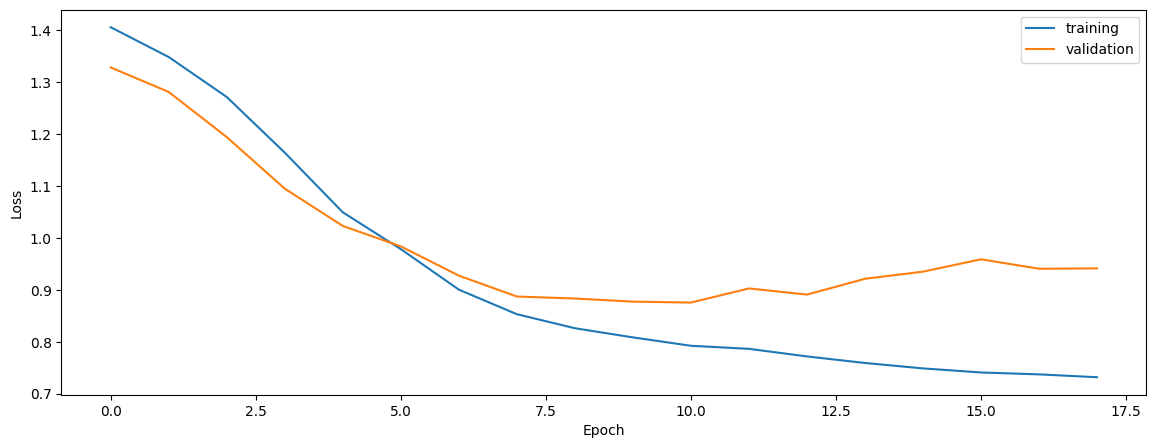

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6962995352810177
0.6549544200342287
0.6036258854604394


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.6962995352810177
0.6549544200342287
0.6036258854604394


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.6914248483937252
0.6593261810653115
0.5959084464249544


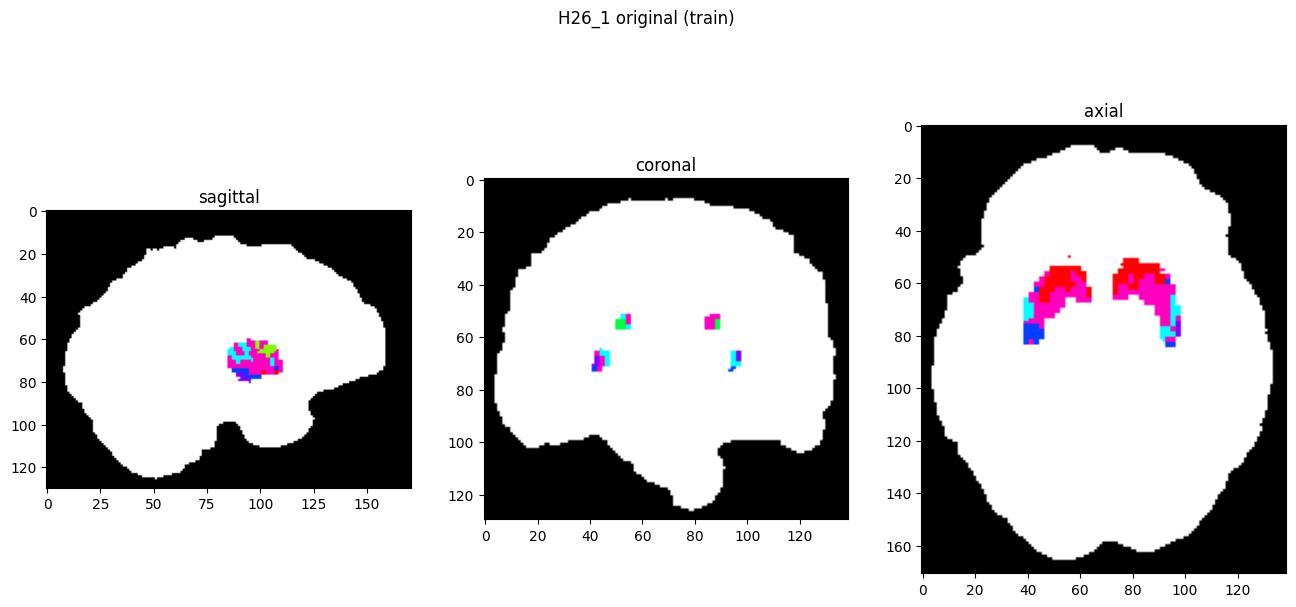

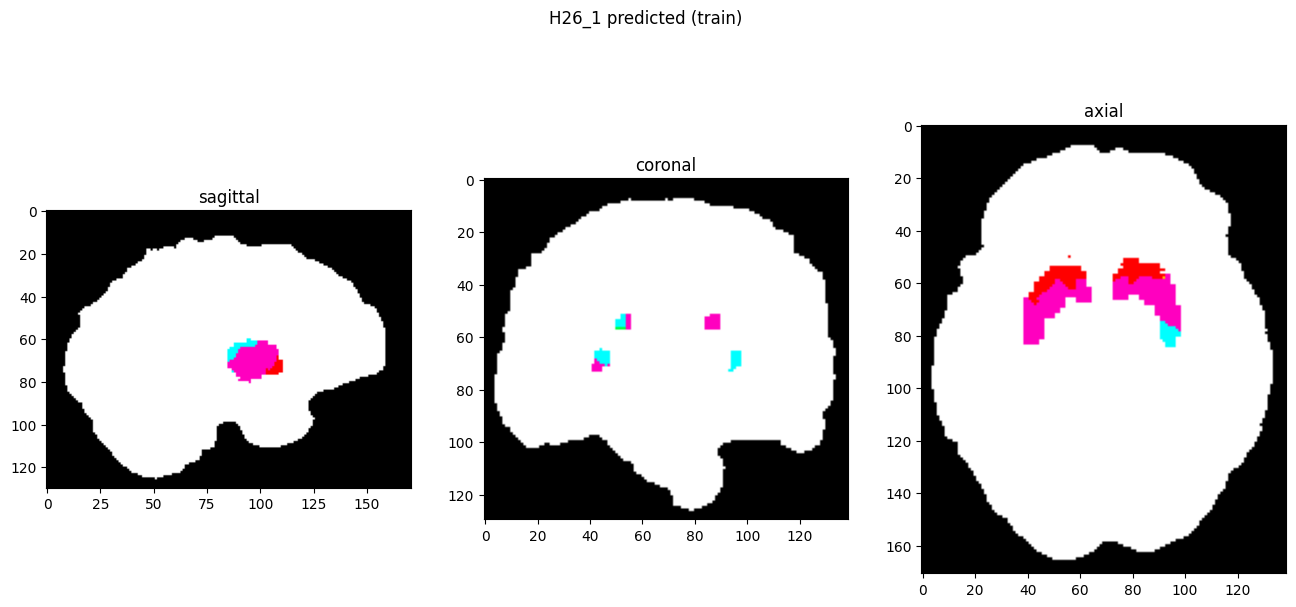

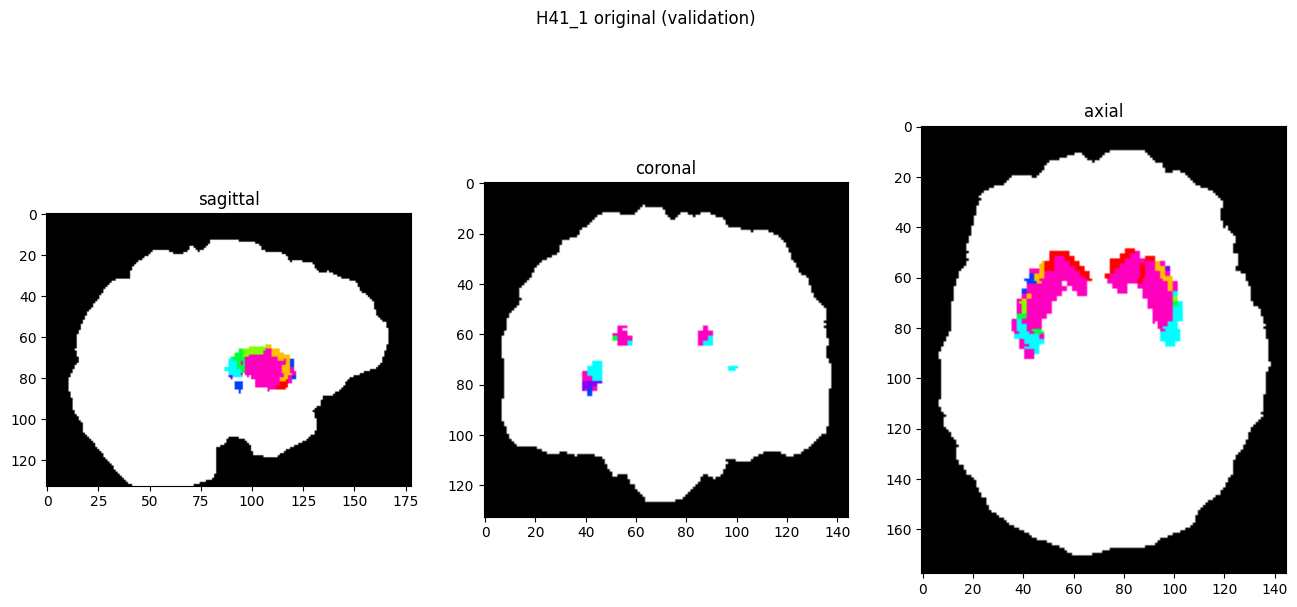

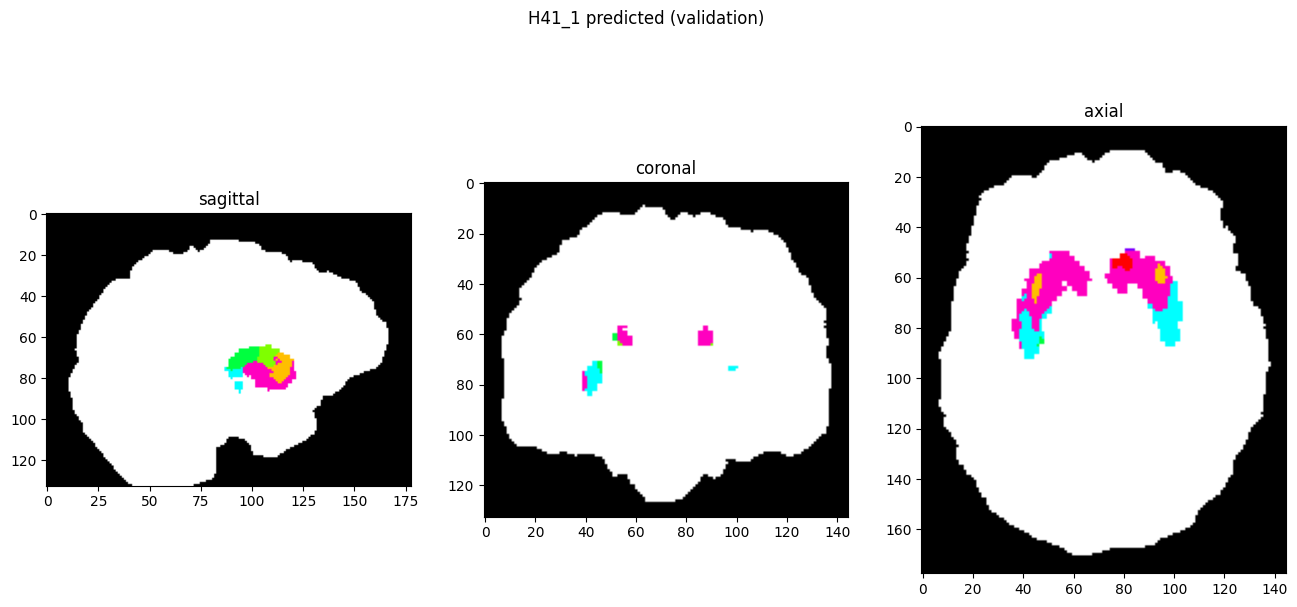

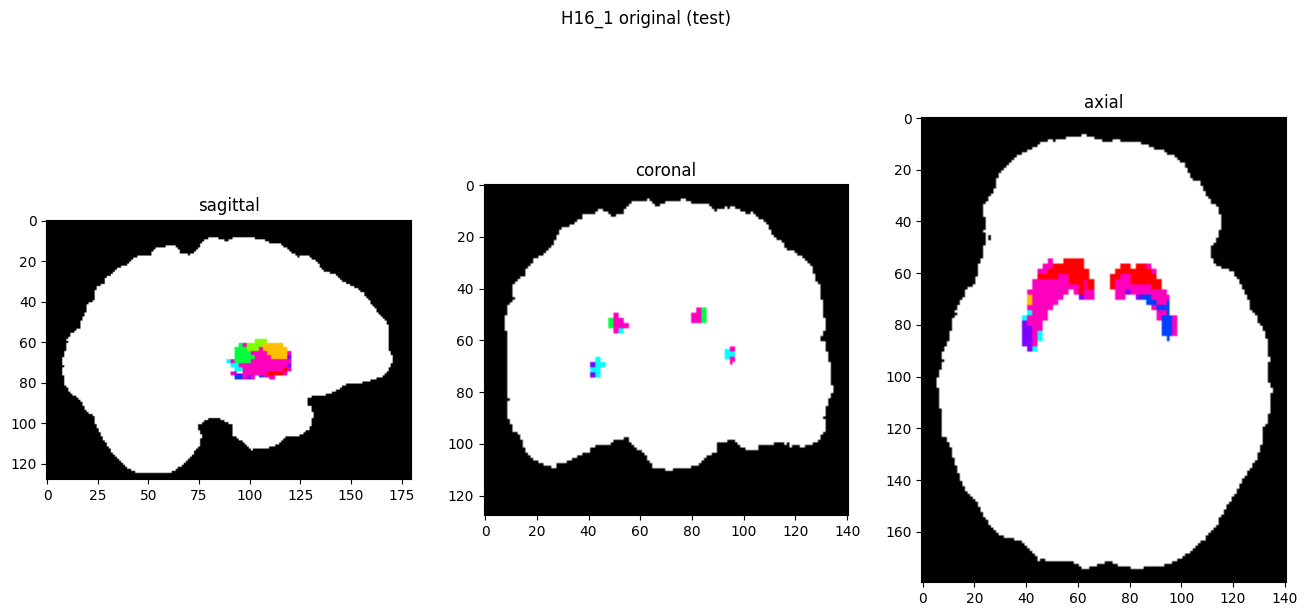

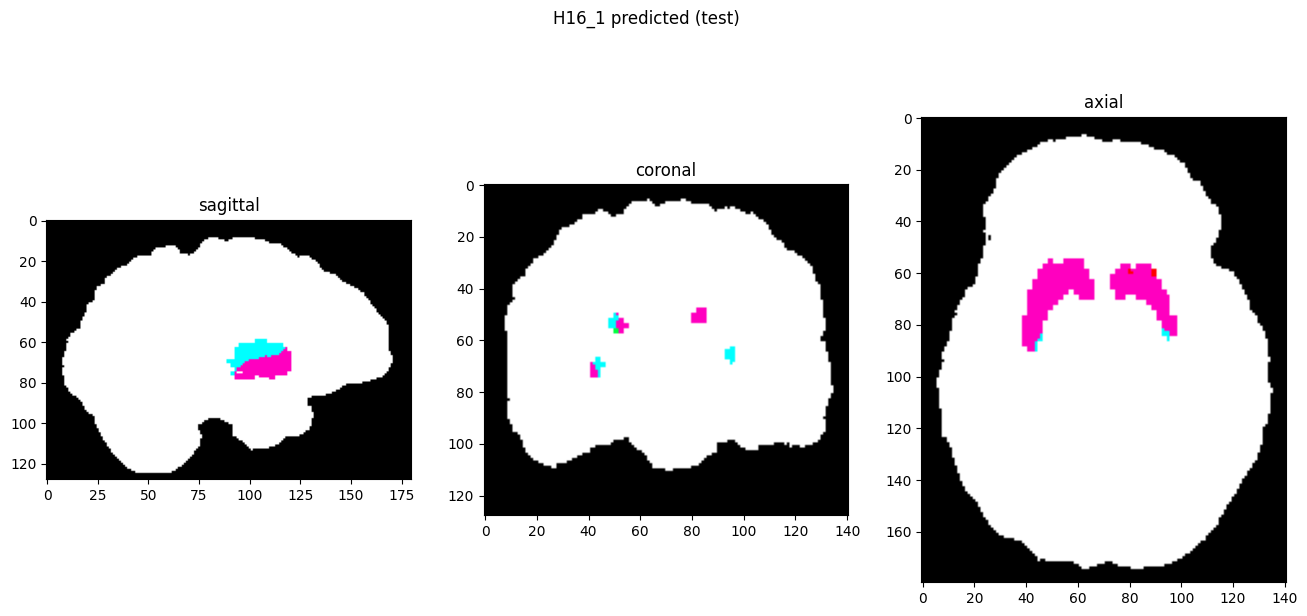

In [10]:
showResults(model, gen, threshold=0)